In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from utils import *

import numpy as np
import cvxopt

cvxopt.solvers.options['show_progress'] = False

%matplotlib inline

In [2]:
"""
Get the preprocessed data:
X and y are dicts, has keys train, val and test. keys gives you what word (or pair of words) each dimension corresponds to.

You can also get bigram features if you call preprocess(bigram = True)`
Another optional argument mincount specifies the frequency cutoff for inclusion of a word/bigram in the
dictionary.

"""
# Our best parameter is bigram = True and mincount = 1. Although we set mincount = 5 here because it takes long time
# to run when mincount is small.
X, y, keys = preprocess(use_bigram = True, mincount = 5)

Feature size:  2049


In [3]:
class Kernel(object):
    """
    A class containing all kinds of kernels.
    Note: the kernel should work for both input (Matrix, vector) and (vector, vector)
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.dot(x, y)
        return f

    @staticmethod
    def gaussian(gamma):  # we use the commonly used name, although it's not really a Gaussian
        def f(x, y):
            exponent = - gamma * np.linalg.norm((x-y).transpose(), 2, 0) ** 2
            return np.exp(exponent)
        return f

    @staticmethod
    def _poly(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._poly(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

In [4]:
class SVM(object):
    def __init__(self, kernel, c):
        """
        Build a SVM given kernel function and C

        Parameters
        ----------
        kernel : function
            a function takes input (Matrix, vector) or (vector, vector)
        c : a scalar
            balance term

        Returns
        -------
        """
        self._kernel = kernel
        self._c = c

    def fit(self, X, y):
        """
        Fit the model given data X and ground truth label y

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        -------
        """
        # Solve the QP problem to get the multipliers
        lagrange_multipliers = self._compute_multipliers(X, y)
        # Get all the support vectors, support weights and bias
        self._construct_predictor(X, y, lagrange_multipliers)
    
    def predict(self, X):
        """
        Predict the label given data X

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        y : 1D array
            predicted label
        """
        result = np.full(X.shape[0], self._bias) # allocate
        
#         YOUR CODE HERE
        for ind in range(X.shape[0]):
            K = self._kernel(self._support_vectors, X[ind])
            result[ind] = np.sum(np.multiply(self._weights, np.multiply(self._support_vector_labels, K))) + self._bias
        return np.sign(result)

    def _kernel_matrix(self, X):
        """
        Get the kernel matrix.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)

        Returns
        -------
        K : 2D array
            N x N kernel matrix
        """
        N, d = X.shape
        K = np.zeros((N, N))
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        """
        Given the data, label and the multipliers, extract the support vectors and calculate the bias

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label
        lagrange_multipliers: 1D array
            the solution of lagrange_multiplier

        Fills in relevant variables: model bias and weights (alphas), and details of support vectors
        
        -------
        """
        support_vector_indices = \
            lagrange_multipliers > 1e-5
            
        print("SV number: ", np.sum(support_vector_indices))

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        """
        Get the bias term (w_0)
        """
#         YOUR CODE HERE
        K = self._kernel_matrix(X)


        support_kernels = K.T[support_vector_indices]
        sv_number = np.sum(support_vector_indices)
        N = y.shape
        omega0 = []
        for ind in range(sv_number):
            if support_multipliers[ind] < self._c - 1e-5:
                omega0.append(1.0/support_vector_labels[ind] - np.sum(np.multiply(lagrange_multipliers, np.multiply(y, support_kernels[ind]))))
        bias = np.mean(omega0)
        print("bias mean/std:{}/{}".format(bias, np.std(omega0)))
    
        self._bias=bias
        self._weights=support_multipliers
        self._support_vectors=support_vectors
        self._support_vector_labels=support_vector_labels

    def _compute_multipliers(self, X, y):
        """
        Given the data, label, solve the QP program to get lagrange multiplier.

        Parameters
        ----------
        X : 2D array
            N x d data matrix (row per example)
        y : 1D array
            class label

        Returns
        lagrange_multipliers: 1D array
        -------
        """
        N, d = X.shape

        K = self._kernel_matrix(X)
        """
        The standard QP solver formulation:
        min 1/2 x^T H x + f^T x
        s.t.
        Ax <=  a
        Bx = b
        """
        H = np.dot(np.dot(np.diag(y), K),np.diag(y))
        H = cvxopt.matrix(H)
        f = -np.ones([N])
        f = cvxopt.matrix(f)

        A = np.concatenate((np.eye(N), -np.eye(N)), axis = 0)
        a = np.concatenate((self._c * np.ones(N), np.zeros(N)))
        A = cvxopt.matrix(A)
        a = cvxopt.matrix(a)
        
        

        B = y
        b = np.zeros([1])
        B = cvxopt.matrix(B).T
        b = cvxopt.matrix(b)
#         print(B.size)
        
        # call the QP solver
        solution = cvxopt.solvers.qp(H, f, A, a, B, b)

        # Lagrange multipliers (the unknown vector 'x' is our alphas)
        return np.ravel(solution['x'])

Test the trainer.
The following code would generate data which the grounth truth split is x+y = 0.5.

SV number:  4
bias mean/std:-5.0910280313/0.0496562519769


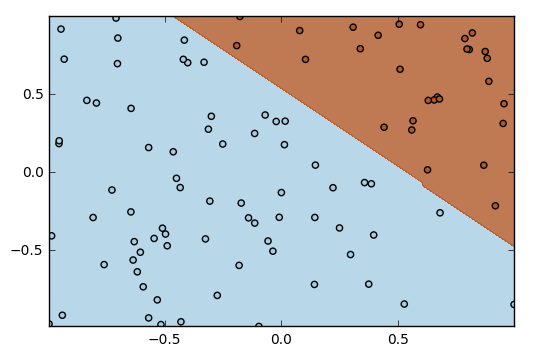

In [5]:
clf = SVM(Kernel.linear(), 100)
test_linear_SVM(clf, 100)

SV number:  15
bias mean/std:8.24828076233/0.0449237414081


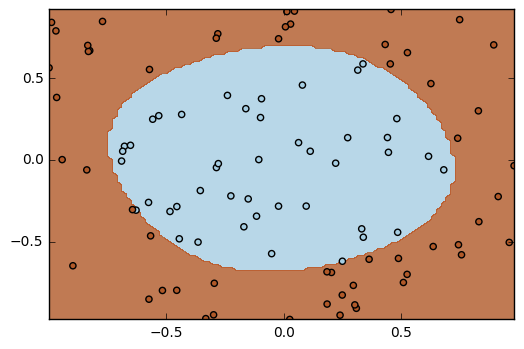

In [6]:
clf = SVM(Kernel.gaussian(1), 100)
test_rbf_SVM(clf, 100)

If you think your code is correct, then we can move to the real problem. Below are some code examples; you will need to fill in some details, and extend these to any experiments you want to run.

In [7]:
# Best C for mincount = 1: C = 10
c_range = [pow(10.0, i) for i in range(-2, 3)]
c_max = 0
acc_max = -10
for C in c_range:
    clf = SVM(Kernel.linear(), C)
    clf.fit(X['train'], y['train'].astype('double'))
    print("C = ", C)
    y_hat = clf.predict(X['train'])
    print("Acc on train: ", np.mean(y_hat == y['train']))
    y_hat = clf.predict(X['val'])
    print("Acc on val: ", np.mean(y_hat == y['val']))
    acc = np.mean(y_hat == y['val'])
    if acc > acc_max:
        c_max = C
        acc_max = acc
print("best c: {}, max acc: {}".format(c_max, acc_max))

SV number:  2214
bias mean/std:0.984902411777/0.000159550671949
C =  0.01
Acc on train:  0.636396396396
Acc on val:  0.67
SV number:  2186
bias mean/std:0.849170412331/0.000250605800176
C =  0.1
Acc on train:  0.641801801802
Acc on val:  0.67
SV number:  1928
bias mean/std:0.391146469013/0.00104836621485
C =  1.0
Acc on train:  0.882882882883
Acc on val:  0.73
SV number:  1509
bias mean/std:0.503731792151/0.002295364908
C =  10.0
Acc on train:  0.962882882883
Acc on val:  0.728
SV number:  1323
bias mean/std:0.999879049583/0.00246367896646
C =  100.0
Acc on train:  0.990990990991
Acc on val:  0.724
best c: 1.0, max acc: 0.73


Choose the best C, and predict the label for test data.

In [ ]:
C = c_max
clf = SVM(Kernel.linear(), C)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_linear.csv', y_hat)


SV number:  1928
bias mean/std:0.391146469013/0.00104836621485


RBF (Gaussian) kernel SVM

In [ ]:
# Best C and gamma for mincount = 1: C = 100.0 and gamma = 0.1
c_range = [1.0, 10.0, 100.0, 1000.0] 
gamma_range = [0.1, 1.0, 10.0]
c_max = 0
gamma_max = 0
acc_max = -10
for C in c_range:
    for gamma in gamma_range:
        clf = SVM(Kernel.gaussian(gamma), C)
        clf.fit(X['train'], y['train'].astype('double'))
        print("C = ", C)
        print("gamma = ", gamma)
        y_hat = clf.predict(X['train'])
        print("Acc on train: ", np.mean(y_hat == y['train']))
        y_hat = clf.predict(X['val'])
        print("Acc on val: ", np.mean(y_hat == y['val']))
        acc = np.mean(y_hat == y['val'])
        if acc > acc_max:
            gamma_max = gamma
            c_max = C
            acc_max = acc
print("best c: {}, best gamma: {}, max acc: {}".format(c_max, gamma_max, acc_max))

SV number:  2301
bias mean/std:-0.98052173783/0.0126454039389
C =  1.0
gamma =  0.1
Acc on train:  0.678558558559
Acc on val:  0.68
SV number:  2495
bias mean/std:-0.0888478767012/0.000975085387598
C =  1.0
gamma =  1.0
Acc on train:  0.967927927928
Acc on val:  0.736
SV number:  2775
bias mean/std:0.425476416868/1.91644934755e-07
C =  1.0
gamma =  10.0
Acc on train:  0.992072072072
Acc on val:  0.674
SV number:  1988
bias mean/std:-6.3762337674/0.0272663733717
C =  10.0
gamma =  0.1
Acc on train:  0.928648648649
Acc on val:  0.738
SV number:  2556
bias mean/std:-0.288048094866/0.0011521543799
C =  10.0
gamma =  1.0
Acc on train:  0.992072072072
Acc on val:  0.754
SV number:  2775
bias mean/std:0.270864046129/7.17794087387e-08
C =  10.0
gamma =  10.0
Acc on train:  0.992072072072
Acc on val:  0.674
SV number:  1705
bias mean/std:-7.80783697238/0.00403380127866
C =  100.0
gamma =  0.1
Acc on train:  0.991351351351
Acc on val:  0.74
SV number:  2623
bias mean/std:-0.289168961905/0.010012

In [ ]:
clf = SVM(Kernel.gaussian(gamma_max), c_max)
clf.fit(X['train'], y['train'].astype('double'))
y_hat = clf.predict(X['test'])
save_submission('sub_rbf.csv', y_hat)
